In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
        
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Exercise 10.

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train_full = x_train_full / 255
x_test = x_test / 255

x_train, x_valid = x_train_full[10000:], x_train_full[:10000]
y_train, y_valid = y_train_full[10000:], y_train_full[:10000]

In [4]:
x_train.shape

(50000, 28, 28)

In [5]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Reshape([28, 28, 1])(inputs)
z = keras.layers.Conv2D(32, kernel_size=3, activation='relu')(z)
z = keras.layers.Conv2D(32, kernel_size=3, activation='relu')(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(z)
z = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(32, activation='relu')(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(28 * 28, activation='relu')(decoder_inputs)
x = keras.layers.Reshape([28, 28, 1])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, padding='same', 
                                 activation='relu')(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, padding='same', 
                                 activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', 
                                 activation='relu')(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', 
                                 activation='relu')(x)
outputs = keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', 
                       optimizer='rmsprop', 
                       metrics=[rounded_accuracy])

In [7]:
variational_ae.fit(x_train, x_train, epochs=20, batch_size=128,
                   validation_data=(x_valid, x_valid))

Epoch 1/20
391/391 [==============================] - 32s 74ms/step - loss: 11.0138 - rounded_accuracy: 0.8874 - val_loss: 0.3125 - val_rounded_accuracy: 0.9186
Epoch 2/20
391/391 [==============================] - 29s 75ms/step - loss: 0.1801 - rounded_accuracy: 0.9292 - val_loss: 0.1841 - val_rounded_accuracy: 0.9312
Epoch 3/20
391/391 [==============================] - 31s 79ms/step - loss: 0.1667 - rounded_accuracy: 0.9384 - val_loss: 0.1723 - val_rounded_accuracy: 0.9360
Epoch 4/20
391/391 [==============================] - 29s 73ms/step - loss: 0.1596 - rounded_accuracy: 0.9432 - val_loss: 0.1878 - val_rounded_accuracy: 0.9274
Epoch 5/20
391/391 [==============================] - 31s 78ms/step - loss: 0.1554 - rounded_accuracy: 0.9459 - val_loss: 0.1553 - val_rounded_accuracy: 0.9484
Epoch 6/20
391/391 [==============================] - 32s 81ms/step - loss: 0.1522 - rounded_accuracy: 0.9480 - val_loss: 0.1519 - val_rounded_accuracy: 0.9491
Epoch 7/20
391/391 [===================

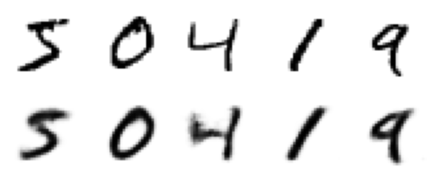

In [8]:
show_reconstructions(variational_ae, x_valid)

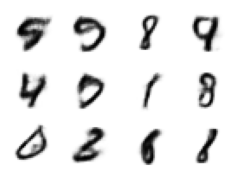

In [9]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)